# Tensorflow Network 3

### Making a score predictor with an RNN

In [1]:
import tensorflow as tf
import tensorflow.keras.layers as tfl
import pandas as pd
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt
current_dir = Path.cwd()
parent_dir = current_dir.parent.parent
from sklearn.preprocessing import MinMaxScaler
input_scaler = MinMaxScaler()
output_scaler = MinMaxScaler()
player_scaler = MinMaxScaler()

from tensorflow.keras.regularizers import l2

### Getting the data

In [2]:
dev_data = pd.read_pickle(parent_dir/"Resources"/"FinalData"/"dev_data.pkl")
test_data = pd.read_pickle(parent_dir/"Resources"/"FinalData"/"test_data.pkl")
training_data = pd.read_pickle(parent_dir/"Resources"/"FinalData"/"training_data.pkl")
dev_data.columns.get_level_values(0).unique()

Index(['Player Status', 'Inning Data', 'Batting Stats', 'Bowling Stats',
       'Ground Data', 'Final Output'],
      dtype='object')

In [3]:
training_data['Bowling Stats']

P1                                        \
                                 Mat       Inns     Overs      Mdns   Runs   
        Country      Over Ball                                               
1144161 Pakistan     0    0     51.0   1.000000   1.00000  0.000000   21.0   
                          1     51.0   1.000000   1.00000  0.000000   21.0   
                          2     51.0   1.000000   1.00000  0.000000   21.0   
                          3     51.0   1.000000   1.00000  0.000000   21.0   
                          4     51.0   1.000000   1.00000  0.000000   21.0   
...                              ...        ...       ...       ...    ...   
356014  South Africa 19   1     37.0  10.710938  32.78125  0.453857  242.0   
                          2     37.0  10.710938  32.78125  0.453857  242.0   
                          3     37.0  10.710938  32.78125  0.453857  242.0   
                          4     37.0  10.710938  32.78125  0.453857  242.0   
                          5     37.0  10.710938  32.78125  0.453857  242.0   

                                                                   P2  \
                                     Wkts       Ave       Econ    Mat   
        Country      Over Ball                                          
1144161 Pakistan     0    0      0.000000  28.03125  21.000000    2.0   
                          1      0.000000  28.03125  21.000000    2.0   
                          2      0.000000  28.03125  21.000000    2.0   
                          3      0.000000  28.03125  21.000000    2.0   
                          4      0.000000  28.03125  21.000000    2.0   
...                                   ...       ...        ...    ...   
356014  South Africa 19   1     10.523438  28.03125   8.039062  148.0   
                          2     10.523438  28.03125   8.039062  148.0   
                          3     10.523438  28.03125   8.039062  148.0   
                          4     10.523438  28.03125   8.039062  148.0   
                          5     10.523438  28.03125   8.039062  148.0   

                                           ...        P10             P11  \
                                     Inns  ...        Ave      Econ   Mat   
        Country      Over Ball             ...                              
1144161 Pakistan     0    0     10.710938  ...  23.609375  9.593750  61.0   
                          1     10.710938  ...  23.609375  9.593750  61.0   
                          2     10.710938  ...  23.609375  9.593750  61.0   
                          3     10.710938  ...  23.609375  9.593750  61.0   
                          4     10.710938  ...  23.609375  9.593750  61.0   
...                                   ...  ...        ...       ...   ...   
356014  South Africa 19   1      9.000000  ...  15.000000  6.808594  14.0   
                          2      9.000000  ...  15.000000  6.808594  14.0   
                          3      9.000000  ...  15.000000  6.808594  14.0   
                          4      9.000000  ...  15.000000  6.808594  14.0   
                          5      9.000000  ...  15.000000  6.808594  14.0   

                                                                              \
                                Inns     Overs Mdns    Runs  Wkts        Ave   
        Country      Over Ball                                                 
1144161 Pakistan     0    0     61.0  218.3750  1.0  1594.0  74.0  21.546875   
                          1     61.0  218.3750  1.0  1594.0  74.0  21.546875   
                          2     61.0  218.3750  1.0  1594.0  74.0  21.546875   
                          3     61.0  218.3750  1.0  1594.0  74.0  21.546875   
                          4     61.0  218.3750  1.0  1594.0  74.0  21.546875   
...                              ...       ...  ...     ...   ...        ...   
356014  South Africa 19   1     14.0   46.1875  0.0   400.0   8.0  50.000000   
                          2     14.0   

## We need to augment data for the current striker, non-striker and bowler

- In order to do that I will be defining a function and applying that on my dataframe.

In [4]:
def return_striker(each_row):
    try:
        striker = each_row['Player Status']['Batting Team'][each_row['Player Status']['Batting Team'] == 10].index[0]
    except:
        striker = 'P1'
    
    try:
        non_striker = each_row['Player Status']['Batting Team'][each_row['Player Status']['Batting Team'] == 5].index[0]
    except:
        non_striker = 'P2'
    
    bowler = each_row['Player Status']['Bowling Team'][each_row['Player Status']['Bowling Team'] == 10].index[0]
    return pd.concat([each_row['Batting Stats'][striker][['Ave', 'SR']], each_row['Batting Stats'][non_striker][['Ave', 'SR']], each_row['Bowling Stats'][bowler][['Ave', 'Econ']]], keys = ['Striker', 'Non Striker', 'Bowler'])

In [5]:
my_row = training_data.iloc[0]
my_row['Batting Stats']['P1'].loc[['Mat', 'Inns']]
# my_row[my_row == 10].index[0]

return_striker(my_row)

Striker      Ave      21.703125
             SR      128.125000
Non Striker  Ave      41.468750
             SR      128.375000
Bowler       Ave      25.078125
             Econ      9.187500
Name: (1144161, Pakistan, 0, 0), dtype: float64

In [ ]:
training_x_players = training_data.apply(return_striker, axis = 1)

In [ ]:
dev_x_players = dev_data.apply(return_striker, axis = 1)

## As this data was hard to process, we will save it on disc to process later

In [ ]:
training_x_players.to_pickle(parent_dir/"Resources"/"FinalData"/"train_x_players.pkl")
dev_x_players.to_pickle(parent_dir/"Resources"/"FinalData"/"dev_x_players.pkl")

In [4]:
training_x_players = pd.read_pickle(parent_dir/"Resources"/"FinalData"/"train_x_players.pkl")
dev_x_players = pd.read_pickle(parent_dir/"Resources"/"FinalData"/"dev_x_players.pkl")

In [5]:
training_x_inning = training_data['Inning Data'].loc[:, [ ('Inning Data','Total Runs'), ('Inning Data','Out')]]
training_x_ground = training_data['Ground Data']
training_y = training_data['Final Output']

dev_data_x = dev_data['Inning Data'].loc[:, [('Inning Data','Total Runs'), ('Inning Data','Out')]]
dev_x_ground = dev_data['Ground Data']
dev_data_y = dev_data['Final Output']

output_scaler.fit(training_y.to_numpy(dtype = 'float32'))
input_scaler.fit(training_x_inning.to_numpy(dtype = 'float32'))
player_scaler.fit(training_x_players.to_numpy(dtype = 'float32'))

print(training_x_inning.shape)
print(training_x_ground.shape)
print(training_y.shape)
print()
print(dev_data_x.shape)
print(dev_x_ground.shape)
print(dev_data_y.shape)

(254741, 2)
(254741, 245)
(254741, 1)

(23618, 2)
(23618, 245)
(23618, 1)


### Making sure all of these matches are padded

In [6]:
## Using masking and padding to make all the data properly input

data = {}
x = 0
for each in [(training_x_inning, 'train_x_inn'), (training_y, 'train_y'), (dev_data_x, 'dev_x_inn'), (dev_data_y, 'dev_y'), (training_x_players, 'train_x_pl'), (dev_x_players, 'dev_x_pl')]:
    eachgroup = each[0].groupby(level = [0, 1])
    eachdata = []
    for index, group in eachgroup:
        
        group = group.to_numpy(dtype = 'float32')
        if x >= 4:
            group = player_scaler.transform(group)
            
        else:    
            if x % 2 != 0:
                group = output_scaler.transform(group)
            else:
                group = input_scaler.transform(group)
                
                
        eachdata.append(group)
        
        eachdata_padded = tf.keras.preprocessing.sequence.pad_sequences(eachdata, maxlen = 150, padding = 'post', value = -1, dtype = 'float32')
    
    data[each[1]] = eachdata_padded
    print(eachdata_padded.shape)
    x = x + 1



(2200, 150, 2)
(2200, 150, 1)
(200, 150, 2)
(200, 150, 1)
(2200, 150, 6)
(200, 150, 6)


In [7]:
datakeys = ['train_x_inn', 'train_x_pl', 'train_y', 'dev_x_inn', 'dev_x_pl', 'dev_y']

In [8]:
data_tens = {}
mask = {}
for key in datakeys:
    mask[key] = data[key] != -1
    data_tens[key] = tf.convert_to_tensor(data[key])
    print(data_tens[key].shape)

(2200, 150, 2)
(2200, 150, 6)
(2200, 150, 1)
(200, 150, 2)
(200, 150, 6)
(200, 150, 1)


## Defining some functions

In [9]:
# This class defines the accuracy

class CountAroundRange(tf.keras.metrics.Metric):
    def __init__(self, range_tolerance, name='count_around_range', **kwargs):
        super(CountAroundRange, self).__init__(name=name, **kwargs)
        self.range_tolerance = range_tolerance
        self.total_samples = self.add_weight(name='total_samples', initializer='zeros')
        self.true_within_range = self.add_weight(name='true_within_range', initializer='zeros')

    def update_state(self, y_true, y_pred, sample_weight=None):
        y_true = tf.cast(y_true, tf.float32)
        y_pred = tf.cast(y_pred, tf.float32)
        in_range = tf.math.abs(y_true - y_pred) <= self.range_tolerance
        in_range = tf.cast(in_range, tf.float32)

        self.total_samples.assign_add(tf.cast(tf.shape(in_range)[0], tf.float32))
        self.true_within_range.assign_add(tf.reduce_sum(in_range))

    def result(self):
        return self.true_within_range / self.total_samples
    
count_20 = CountAroundRange(range_tolerance = 1, name = 'Count_20')
count_10 = CountAroundRange(range_tolerance = 0.5, name = 'Count_10')

## Proposed Model

- The model will be taking ball by ball data and feeding it inside an RNN after padding it and masking it

In [10]:
input_inning = tfl.Input(shape = (150, 2))
input_players = tfl.Input(shape = (150, 6))
input_layer = tfl.Concatenate(axis = -1)([input_inning, input_players])
masked_input = tfl.Masking(mask_value = -1)(input_layer)
output = tfl.SimpleRNN(units = 128, return_sequences = True, activation ='relu', kernel_regularizer=l2(0.01))(masked_input)
output = tfl.Dropout(0.2)(output)
output = tfl.SimpleRNN(units = 128, return_sequences = True, activation = 'relu', kernel_regularizer=l2(0.01))(output)
output = tfl.Dropout(0.2)(output)
output = tfl.TimeDistributed(tfl.Dense(8, activation = 'relu', kernel_regularizer=l2(0.01)))(output)
output = tfl.TimeDistributed(tfl.Dense(1))(output)

model = tf.keras.models.Model(inputs = [input_inning, input_players], outputs = output)

model.compile(optimizer = 'adam', loss = 'MSE')

model.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 150, 2)]     0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 150, 6)]     0                                            
__________________________________________________________________________________________________
concatenate (Concatenate)       (None, 150, 8)       0           input_1[0][0]                    
                                                                 input_2[0][0]                    
__________________________________________________________________________________________________
masking (Masking)               (None, 150, 8)       0           concatenate[0][0]     

In [21]:
new_model_layer = model.layers[4].output
new_model_layer = model.layers[6](new_model_layer)
new_model_layer = model.layers[8](new_model_layer)
new_output = model.layers[9](new_model_layer)

new_model = tf.keras.models.Model(inputs = model.input, outputs = new_output)

new_model.compile(optimizer = 'adam', loss = 'MSE')
new_model.summary()


Model: "functional_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 150, 2)]     0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 150, 6)]     0                                            
__________________________________________________________________________________________________
concatenate (Concatenate)       (None, 150, 8)       0           input_1[0][0]                    
                                                                 input_2[0][0]                    
__________________________________________________________________________________________________
masking (Masking)               (None, 150, 8)       0           concatenate[0][0]     

In [25]:
num_epochs = 100
batch_size = 128

history = model.fit([data['train_x_inn'], data['train_x_pl']], data['train_y'], sample_weight = [mask['train_y']], epochs = num_epochs, batch_size =batch_size, validation_data = ([data['dev_x_inn'], data['dev_x_pl']], data['dev_y']))

Epoch 1/100
18/18 [==============================] - 3s 165ms/step - loss: 0.0110 - val_loss: 0.0118
Epoch 2/100
18/18 [==============================] - 3s 168ms/step - loss: 0.0109 - val_loss: 0.0114
Epoch 3/100
18/18 [==============================] - 3s 171ms/step - loss: 0.0110 - val_loss: 0.0133
Epoch 4/100
18/18 [==============================] - 3s 168ms/step - loss: 0.0114 - val_loss: 0.0122
Epoch 5/100
18/18 [==============================] - 3s 166ms/step - loss: 0.0111 - val_loss: 0.0130
Epoch 6/100
18/18 [==============================] - 3s 169ms/step - loss: 0.0117 - val_loss: 0.0115
Epoch 7/100
18/18 [==============================] - 3s 165ms/step - loss: 0.0109 - val_loss: 0.0115
Epoch 8/100
18/18 [==============================] - 3s 164ms/step - loss: 0.0109 - val_loss: 0.0114
Epoch 9/100
18/18 [==============================] - 3s 168ms/step - loss: 0.0108 - val_loss: 0.0114
Epoch 10/100
18/18 [==============================] - 3s 168ms/step - loss: 0.0114 - val_lo

KeyboardInterrupt: 

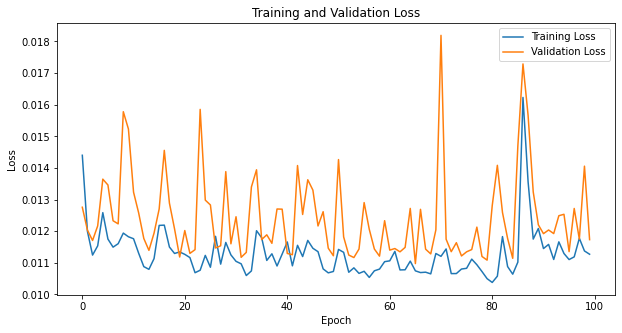

In [23]:
# Plot training loss and validation loss
plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [16]:
dev_loss= model.evaluate([data['dev_x_inn'], data['dev_x_pl']], data['dev_y'])

print(dev_loss)
print ("---------")
train_loss= model.evaluate([data['train_x_inn'], data['train_x_pl']], data['train_y'])
print(train_loss)

7/7 [==============================] - 0s 9ms/step - loss: 0.0103
0.010265499353408813
---------
69/69 [==============================] - 1s 10ms/step - loss: 0.0089
0.0088982954621315


In [35]:
def check_accuracy(y_true, y_pred, range_size, oversS, oversE):
    print(y_true.shape)
    y_true = y_true[:, oversS*6:oversE*6]
    print(y_true.shape)
    y_pred = y_pred[:, oversS*6:oversE*6]
    valid_vals = y_pred >= 0
    y_true = y_true[valid_vals]
    y_pred = y_pred[valid_vals]
    return np.sum(np.abs(output_scaler.inverse_transform(y_pred.reshape(-1,1)) - output_scaler.inverse_transform(y_true.reshape(-1,1))) < range_size) / y_true.shape

In [18]:
data['dev_x_inn']

model.predict([data['dev_x_inn'], data['dev_x_pl']])
mask_val = data['dev_y']>= 0
mask_val2 = data['dev_x_inn'] >= 0
mask_val3 = data['dev_x_pl'] >= 0

data['dev_y'][mask_val].shape

(23618,)

In [36]:
check_accuracy(model.predict([data['dev_x_inn'], data['dev_x_pl']]), data['dev_y'], 10, 0, 5)

(200, 150, 1)
(200, 30, 1)


array([0.23266667])

In [31]:
output_scaler.inverse_transform(model.predict([data['dev_x_inn'][5:6], data['dev_x_pl'][5:6]])[0])

array([[147.88441],
       [147.1256 ],
       [145.76454],
       [152.26678],
       [152.9184 ],
       [153.61684],
       [157.45592],
       [160.85852],
       [161.29729],
       [160.4767 ],
       [160.33055],
       [162.23682],
       [161.48296],
       [164.12648],
       [163.11032],
       [162.66856],
       [162.81458],
       [163.16252],
       [167.38768],
       [167.66118],
       [167.93823],
       [171.4207 ],
       [170.45877],
       [170.67085],
       [170.28238],
       [169.63295],
       [168.9679 ],
       [170.60988],
       [172.70964],
       [173.08641],
       [176.08656],
       [174.43816],
       [175.35713],
       [175.10489],
       [177.7758 ],
       [170.87422],
       [171.66122],
       [170.22217],
       [168.90373],
       [166.96506],
       [166.23375],
       [165.90129],
       [165.73436],
       [159.12079],
       [157.74442],
       [156.40897],
       [156.20522],
       [156.06221],
       [159.41415],
       [159.22372],


In [30]:
output_scaler.inverse_transform(data['dev_y'][5])

array([[ 164.     ],
       [ 164.     ],
       [ 164.     ],
       [ 164.     ],
       [ 164.     ],
       [ 164.     ],
       [ 164.     ],
       [ 164.     ],
       [ 164.     ],
       [ 164.     ],
       [ 164.     ],
       [ 164.     ],
       [ 164.     ],
       [ 164.     ],
       [ 164.     ],
       [ 164.     ],
       [ 164.     ],
       [ 164.     ],
       [ 164.     ],
       [ 164.     ],
       [ 164.     ],
       [ 164.     ],
       [ 164.     ],
       [ 164.     ],
       [ 164.     ],
       [ 164.     ],
       [ 164.     ],
       [ 164.     ],
       [ 164.     ],
       [ 164.     ],
       [ 164.     ],
       [ 164.     ],
       [ 164.     ],
       [ 164.     ],
       [ 164.     ],
       [ 164.     ],
       [ 164.     ],
       [ 164.     ],
       [ 164.     ],
       [ 164.     ],
       [ 164.     ],
       [ 164.     ],
       [ 164.     ],
       [ 164.     ],
       [ 164.     ],
       [ 164.     ],
       [ 164.     ],
       [ 164.

# Model # 2

In [67]:
input_inning = tfl.Input(shape = (150, 2))
input_players = tfl.Input(shape = (150, 6))
masked_inning = tfl.Masking(mask_value = -1)(input_inning)
masked_players = tfl.Masking(mask_value = -1)(input_players)
innings = tfl.SimpleRNN(units = 128, return_sequences = True, activation = 'relu')(masked_inning)
innings = tfl.SimpleRNN(units = 256, return_sequences = True, activation = 'relu')(innings)
players = tfl.SimpleRNN(units = 16, return_sequences = True, activation = 'relu')(masked_players)
players = tfl.SimpleRNN(units = 32, return_sequences = True, activation = 'relu')(players)
output = tfl.Concatenate()([innings, players])
output = tfl.Dropout(0.2)(output)
output = tfl.SimpleRNN(units = 32,return_sequences = True, activation = 'relu')(output)
output = tfl.Dropout(0.2)(output)
output = tfl.TimeDistributed(tfl.Dense(16, activation = 'relu'))(output)
output = tfl.SimpleRNN(units = 32, return_sequences = True, activation = 'relu')(output)
output = tfl.TimeDistributed(tfl.Dense(1))(output)

model2 = tf.keras.models.Model(inputs = [input_inning, input_players], outputs = output)

model2.compile(optimizer = 'adam', loss = 'MSE')

model2.summary()

Model: "functional_13"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_11 (InputLayer)           [(None, 150, 2)]     0                                            
__________________________________________________________________________________________________
input_12 (InputLayer)           [(None, 150, 6)]     0                                            
__________________________________________________________________________________________________
masking_9 (Masking)             (None, 150, 2)       0           input_11[0][0]                   
__________________________________________________________________________________________________
masking_10 (Masking)            (None, 150, 6)       0           input_12[0][0]                   
______________________________________________________________________________________

In [68]:
num_epochs = 10
batch_size = 128

history = model2.fit([data['train_x_inn'], data['train_x_pl']], data['train_y'], sample_weight = [mask['train_y']], epochs = num_epochs, batch_size =batch_size, validation_data = ([data['dev_x_inn'], data['dev_x_pl']], data['dev_y']))

Epoch 1/10
18/18 [==============================] - 9s 503ms/step - loss: 0.0732 - val_loss: 0.0255
Epoch 2/10
18/18 [==============================] - 8s 458ms/step - loss: 0.0230 - val_loss: 0.0185
Epoch 3/10
18/18 [==============================] - 8s 431ms/step - loss: 0.0175 - val_loss: 0.0166
Epoch 4/10
18/18 [==============================] - 8s 421ms/step - loss: 0.0160 - val_loss: 0.0158
Epoch 5/10
18/18 [==============================] - 8s 463ms/step - loss: 0.0152 - val_loss: 0.0149
Epoch 6/10
18/18 [==============================] - 8s 449ms/step - loss: 0.0150 - val_loss: 0.0140
Epoch 7/10
18/18 [==============================] - 8s 445ms/step - loss: 0.0138 - val_loss: 0.0136
Epoch 8/10
18/18 [==============================] - 9s 482ms/step - loss: 0.0130 - val_loss: 0.0129
Epoch 9/10
18/18 [==============================] - 8s 468ms/step - loss: 0.0119 - val_loss: 0.0122
Epoch 10/10
18/18 [==============================] - 8s 455ms/step - loss: 0.0111 - val_loss: 0.0125

In [61]:
dev_loss= model2.evaluate([data['dev_x_inn'], data['dev_x_pl']], data['dev_y'])

print(dev_loss)
print ("---------")
train_loss= model2.evaluate([data['train_x_inn'], data['train_x_pl']], data['train_y'])
print(train_loss)

7/7 [==============================] - 0s 39ms/step - loss: 0.0104
0.010434743948280811
---------
69/69 [==============================] - 3s 48ms/step - loss: 0.0094
0.009443304501473904


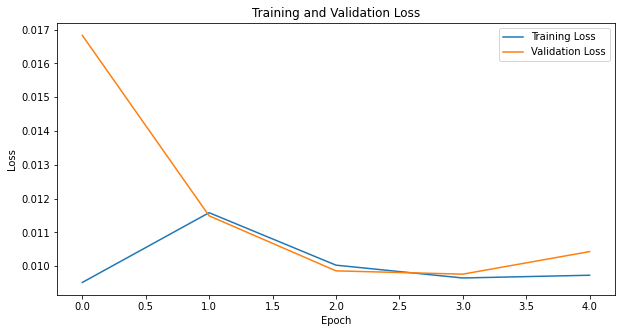

In [62]:
# Plot training loss and validation loss
plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [63]:
check_accuracy(model2.predict([data['dev_x_inn'], data['dev_x_pl']]), data['dev_y'], 10,0 , 20)

(200, 150, 1)
(200, 120, 1)


array([0.34052025])

## 3rd Model

In [86]:
input_inning = tfl.Input(shape = (150, 2))
input_players = tfl.Input(shape = (150, 6))
input_layer = tfl.Concatenate(axis = -1)([input_inning, input_players])
masked_input = tfl.Masking(mask_value = -1)(input_layer)
output = tfl.SimpleRNN(units = 16, return_sequences = True, activation ='relu')(masked_input)
output = tfl.TimeDistributed(tfl.Dense(1))(output)
model3 = tf.keras.models.Model(inputs = [input_inning, input_players], outputs = output)

model3.compile(optimizer = 'adam', loss = 'MSE')

model3.summary()

Model: "functional_23"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_21 (InputLayer)           [(None, 150, 2)]     0                                            
__________________________________________________________________________________________________
input_22 (InputLayer)           [(None, 150, 6)]     0                                            
__________________________________________________________________________________________________
concatenate_10 (Concatenate)    (None, 150, 8)       0           input_21[0][0]                   
                                                                 input_22[0][0]                   
__________________________________________________________________________________________________
masking_15 (Masking)            (None, 150, 8)       0           concatenate_10[0][0] 

In [90]:
num_epochs = 20
batch_size = 256

history = model3.fit([data['train_x_inn'], data['train_x_pl']], data['train_y'], sample_weight = [mask['train_y']], epochs = num_epochs, batch_size =batch_size, validation_data = ([data['dev_x_inn'], data['dev_x_pl']], data['dev_y']))

Epoch 1/20
9/9 [==============================] - 0s 23ms/step - loss: 0.0093 - val_loss: 0.0098
Epoch 2/20
9/9 [==============================] - 0s 19ms/step - loss: 0.0091 - val_loss: 0.0097
Epoch 3/20
9/9 [==============================] - 0s 19ms/step - loss: 0.0091 - val_loss: 0.0099
Epoch 4/20
9/9 [==============================] - 0s 20ms/step - loss: 0.0091 - val_loss: 0.0100
Epoch 5/20
9/9 [==============================] - 0s 20ms/step - loss: 0.0091 - val_loss: 0.0099
Epoch 6/20
9/9 [==============================] - 0s 19ms/step - loss: 0.0092 - val_loss: 0.0097
Epoch 7/20
9/9 [==============================] - 0s 19ms/step - loss: 0.0091 - val_loss: 0.0098
Epoch 8/20
9/9 [==============================] - 0s 19ms/step - loss: 0.0092 - val_loss: 0.0098
Epoch 9/20
9/9 [==============================] - 0s 19ms/step - loss: 0.0091 - val_loss: 0.0100
Epoch 10/20
9/9 [==============================] - 0s 20ms/step - loss: 0.0092 - val_loss: 0.0098
Epoch 11/20
9/9 [============

In [91]:
dev_loss= model3.evaluate([data['dev_x_inn'], data['dev_x_pl']], data['dev_y'])

print(dev_loss)
print ("---------")
train_loss= model3.evaluate([data['train_x_inn'], data['train_x_pl']], data['train_y'])
print(train_loss)

7/7 [==============================] - 0s 4ms/step - loss: 0.0097
0.009726006537675858
---------
69/69 [==============================] - 0s 4ms/step - loss: 0.0091
0.00911388173699379


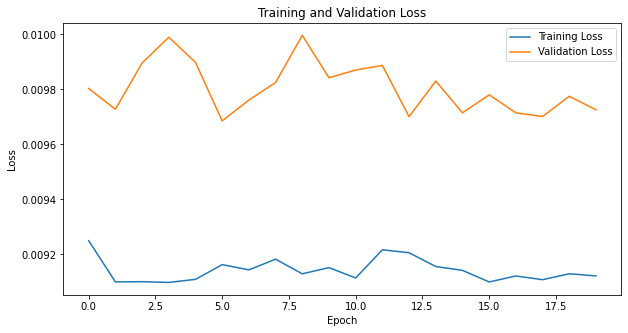

In [92]:
# Plot training loss and validation loss
plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [114]:
check_accuracy(model3.predict([data['dev_x_inn'], data['dev_x_pl']]), data['dev_y'], 20,12 , 16)

(200, 150, 1)
(200, 24, 1)


array([0.6935236])

In [113]:
output_scaler.inverse_transform(model3.predict([data['dev_x_inn'][5:6], data['dev_x_pl'][5:6]])[0])[100]

array([165.28175], dtype=float32)

In [108]:
data['dev_y'][5][data['dev_y'][5] > 0].shape

(111,)

In [105]:
output_scaler.inverse_transform(data['dev_y'][5])

array([[ 164.     ],
       [ 164.     ],
       [ 164.     ],
       [ 164.     ],
       [ 164.     ],
       [ 164.     ],
       [ 164.     ],
       [ 164.     ],
       [ 164.     ],
       [ 164.     ],
       [ 164.     ],
       [ 164.     ],
       [ 164.     ],
       [ 164.     ],
       [ 164.     ],
       [ 164.     ],
       [ 164.     ],
       [ 164.     ],
       [ 164.     ],
       [ 164.     ],
       [ 164.     ],
       [ 164.     ],
       [ 164.     ],
       [ 164.     ],
       [ 164.     ],
       [ 164.     ],
       [ 164.     ],
       [ 164.     ],
       [ 164.     ],
       [ 164.     ],
       [ 164.     ],
       [ 164.     ],
       [ 164.     ],
       [ 164.     ],
       [ 164.     ],
       [ 164.     ],
       [ 164.     ],
       [ 164.     ],
       [ 164.     ],
       [ 164.     ],
       [ 164.     ],
       [ 164.     ],
       [ 164.     ],
       [ 164.     ],
       [ 164.     ],
       [ 164.     ],
       [ 164.     ],
       [ 164.

### Saving this model

In [115]:
model3.save(parent_dir/'Models'/'tfmodel3.h5')

## Checking the errors here

In [46]:
def check_errors(y_true, y_pred, range_size, overs):
    y_true = y_true[overs:]
    y_pred = y_pred[overs:]
    valid_vals = y_pred >= 0
    y_true = y_true[valid_vals]
    y_pred = y_pred[valid_vals]
    
    errors = np.abs(output_scaler.inverse_transform(y_pred.reshape(-1,1)) - output_scaler.inverse_transform(y_true.reshape(-1,1))) < range_size
    return errors

In [51]:
error_mask = check_errors(model2.predict([data['dev_x_inn'], data['dev_x_pl']]), data['dev_y'], 80, 0)
error_mask

array([[ True],
       [ True],
       [ True],
       ...,
       [ True],
       [ True],
       [ True]])

In [52]:
dev_data.loc[error_mask]

Player Status                                 \
                               Batting Team                                  
                                         P1   P2   P3   P4    P5   P6   P7   
        Country     Over Ball                                                
1359787 Argentina   0    0             10.0  5.0  1.0  1.0   1.0  1.0  1.0   
                         1             10.0  5.0  1.0  1.0   1.0  1.0  1.0   
                         2             10.0  5.0  1.0  1.0   1.0  1.0  1.0   
                         3             10.0  5.0  1.0  1.0   1.0  1.0  1.0   
                         4             10.0  5.0  1.0  1.0   1.0  1.0  1.0   
...                                     ...  ...  ...  ...   ...  ...  ...   
1273746 West Indies 19   1              0.0  0.0  0.0  0.0  10.0  0.0  0.0   
                         2              0.0  0.0  0.0  0.0  10.0  0.0  0.0   
                         3              0.0  0.0  0.0  0.0  10.0  0.0  0.0   
                         4              0.0  0.0  0.0  0.0  10.0  0.0  0.0   
                         5              0.0  0.0  0.0  0.0  10.0  0.0  0.0   

                                              ...  \
                                              ...   
                                P8   P9  P10  ...   
        Country     Over Ball                 ...   
1359787 Argentina   0    0     1.0  1.0  1.0  ...   
                         1     1.0  1.0  1.0  ...   
                         2     1.0  1.0  1.0  ...   
                         3     1.0  1.0  1.0  ...   
                         4     1.0  1.0  1.0  ...   
...                            ...  ...  ...  ...   
1273746 West Indies 19   1     0.0  0.0  5.0  ...   
                         2     0.0  0.0  5.0  ...   
                         3     0.0  0.0  5.0  ...   
                         4     0.0  0.0  5.0  ...   
                         5     0.0  0.0  5.0  ...   

                                                            Ground Data  \
                                                                      -   
                              Zahur Ahmed Chowdhury Stadium, Chattogram   
        Country     Over Ball                                             
1359787 Argentina   0    0                                          0.0   
                         1                                          0.0   
                         2                                          0.0   
                         3                                          0.0   
                         4                                          0.0   
...                                                                 ...   
1273746 West Indies 19   1                                          0.0   
                         2                                          0.0   
                         3                                          0.0   
                         4                                          0.0   
                         5                                          0.0   

                                                            \
                                                             
                              St Albans Club, Buenos Aires   
        Country     Over Ball                                
1359787 Argentina   0    0                             0.0   
                         1                             0.0   
                         2                             0.0   
                         3                             0.0   
                         4                             0.0   
...                                                    ...   
1273746 West Indies 19   1                             0.0   
                         2                             0.0   
                         3                             0.0   
                         4                             0.0   
                         5                             0.0   

      

In [ ]:
dev_data.loc[1359787]

## Discarded Code:

In [ ]:
## Old attempt - did not go thorugh this

each_inning_data = []
for index, group in training_x_inning.groupby(level = [0,1]):
    group = group.to_numpy()
    each_inning_data.append(group)

inning_3d = np.array(each_inning_data)
inning_3d[3].shape